# HWK1- Javiera Toro Grey, 20.906.812-5

We are going to characterize data from TOI-163, a star with 1.66 Solar masses and a Tempetature of 6388K, so this is a spectral F-type star.

There is one confirmed exoplanet orbiting the star, TOI-163b, with 1.489 jupyter masses.

Now let's work on the light curve for TOI-163b.

info obtained from: https://exoplanetarchive.ipac.caltech.edu/overview/TOI%20163 and https://ui.adsabs.harvard.edu/abs/2019MNRAS.490.1094K/abstract

In [379]:
# Dependencies
import emcee
import lightkurve as lk
import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

First, let's check the available data from the star in the TESS repository, using the library lightkurve, and in the TESScut webpage

In [5]:
search_result = lk.search_targetpixelfile('TOI-163b', mission='TESS')
search_result

#,mission,year,author,exptime,target_name,distance
,,,,s,,arcsec
0,TESS Sector 11,2019,SPOC,120,179317684,0.0
1,TESS Sector 09,2019,SPOC,120,179317684,0.0
2,TESS Sector 10,2019,SPOC,120,179317684,0.0
3,TESS Sector 13,2019,SPOC,120,179317684,0.0
4,TESS Sector 12,2019,SPOC,120,179317684,0.0
5,TESS Sector 33,2020,SPOC,20,179317684,0.0
6,TESS Sector 32,2020,SPOC,20,179317684,0.0
7,TESS Sector 31,2020,SPOC,20,179317684,0.0
8,TESS Sector 30,2020,SPOC,20,179317684,0.0


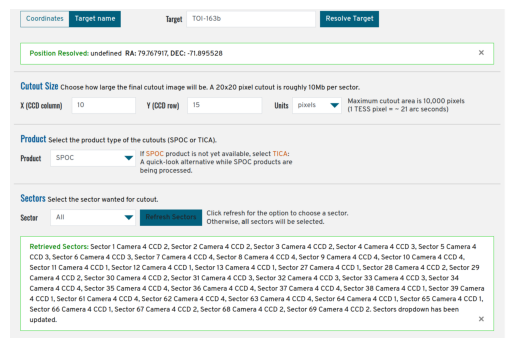

In [276]:
# DO NOR RUN THIS SECTION, JUST TO VISUALIZE WEB PAGE
import matplotlib.image as mpimg

image_path = 'Images/WEB_PAGE.png'
image = mpimg.imread(image_path)

plt.imshow(image)
plt.axis('off')
plt.show()

As the sector is not relevant to the derivation of the light curve, the sector would be decided randomly.

In [235]:
np.random.seed(22)
sector = np.random.randint(1, 80)
print(f'The decided sector would be {sector}')

The decided sector would be 5


Now the FFI data for sector 5 of TOI-163b is downloaded and visualized in a 20x20 stamp

In [236]:
target = 'TOI-163b'
tpf = lk.search_tesscut(target, sector=3).download(cutout_size=(20, 20))
tpf.animate()

# Star Masking

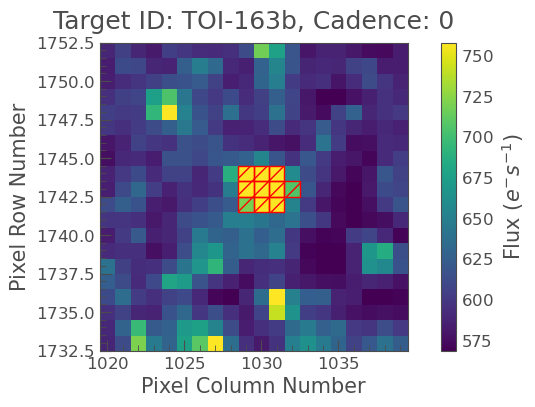

In [243]:
# Star masking
# The thresh is the value for the pixel to be included in the mask,
# the pixel needs to be thresh times sigma brighter than the median flux

thresh = 4
aper = tpf.create_threshold_mask(thresh)
tpf.plot(aperture_mask=aper);

The threshold of 4 was chosen because values below this threshold do not capture parts of the star's flux, while higher values tend to include background light and nearby objects. Here are some examples to illustrate this decision

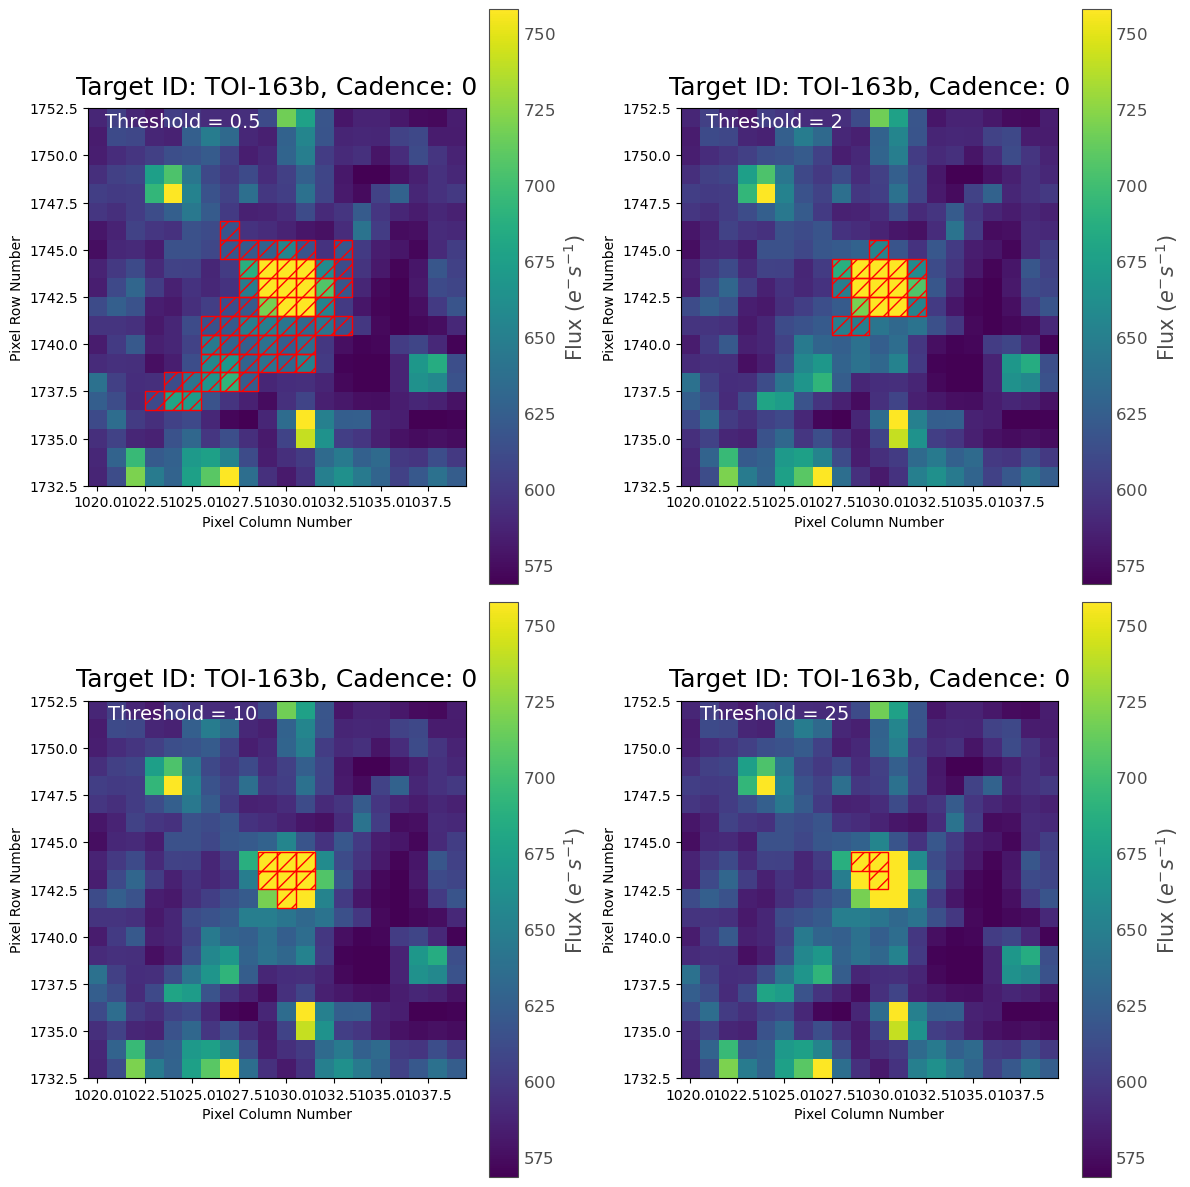

In [247]:
fig, axis_list = plt.subplots(2, 2, figsize=(12, 12))
thresh_list = [0.5, 2, 10, 25]

for i in range(4):
    thresh = thresh_list[i]
    ax = axis_list[i // 2, i % 2]
    aper_plot = tpf.create_threshold_mask(thresh)
    tpf.plot(aperture_mask=aper_plot, ax=ax)
    ax.text(0.25, 0.95, f'Threshold = {thresh}',
            horizontalalignment='center', transform=ax.transAxes,
            color='w', size=14)
    
plt.tight_layout()
plt.show()


# Uncorrected aperture lightcurve

Now, the uncorrected aperture light curve for threshold 4 is plotted below, followed by the  aperture light curves for the example thresholds used before, below that.

Text(0.5, 1.0, 'Aperture Light Curve')

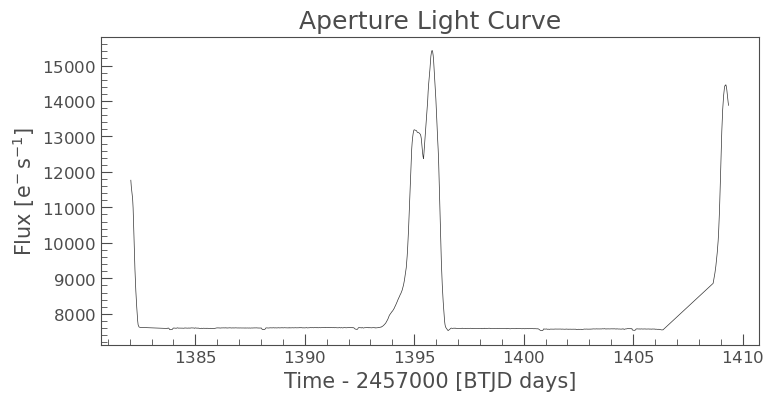

In [248]:
# The uncorrected aperture light curve for threshold 4
uncorrected_lc = tpf.to_lightcurve(aperture_mask=aper)
uncorrected_lc.plot();
plt.title('Aperture Light Curve', fontsize=18)

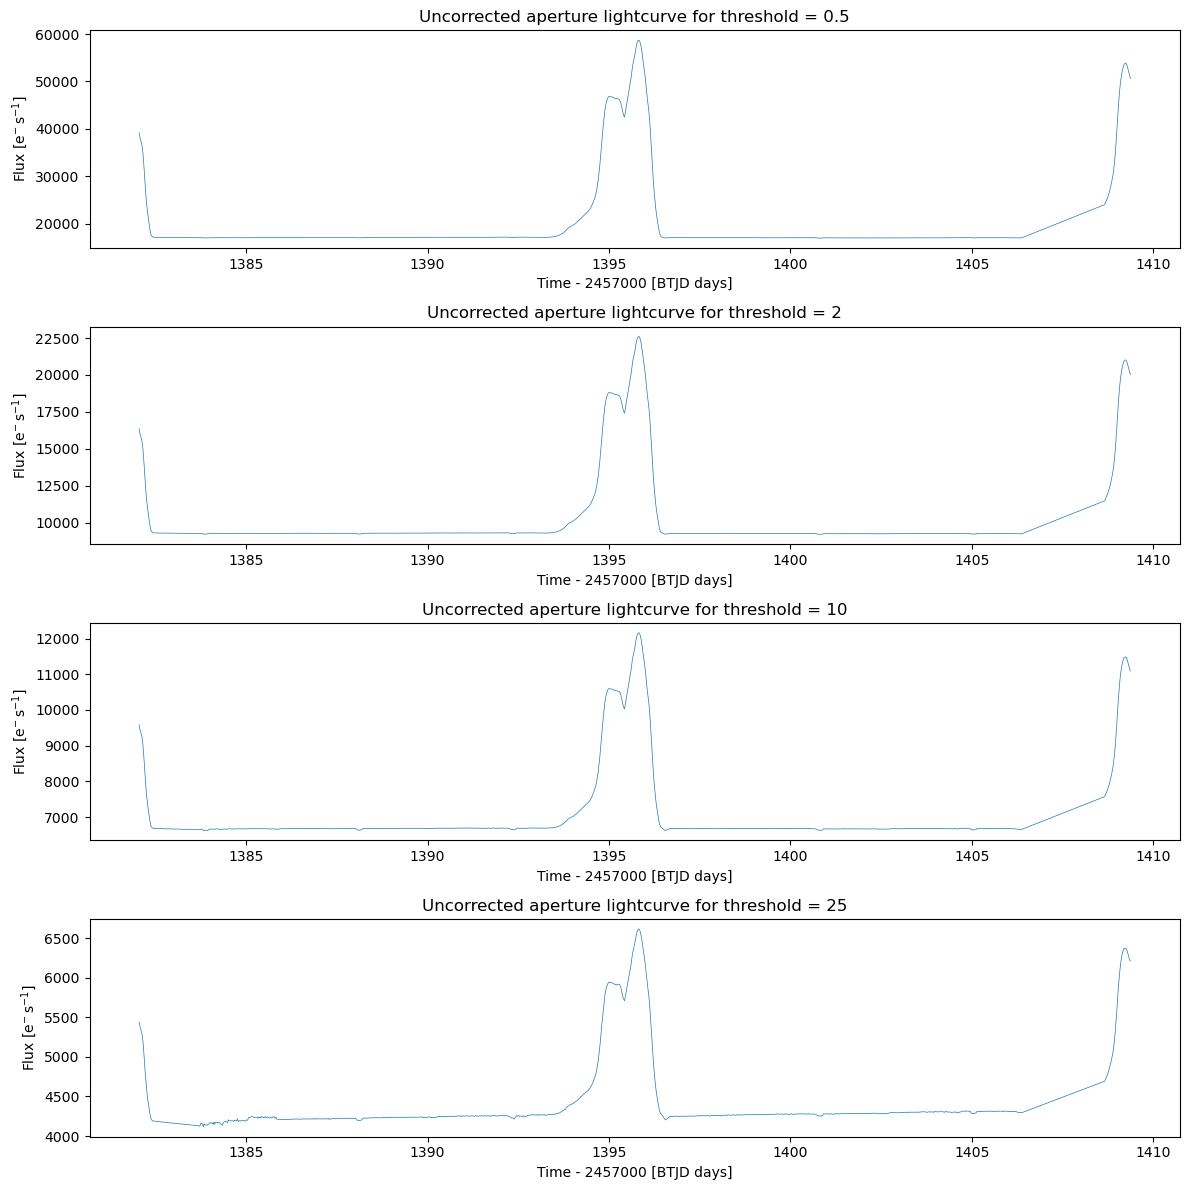

In [249]:
# The uncorrected lightcurves for example thresholds
fig, axis_list = plt.subplots(4, 1, figsize=(12, 12))

for i in range(4):
    thresh = thresh_list[i]
    ax = axis_list[i]
    ax.set_title(f'Uncorrected aperture lightcurve for threshold = {thresh}')
    aper_plot = tpf.create_threshold_mask(thresh)
    uncorrected_lc_plot = tpf.to_lightcurve(aperture_mask=aper_plot)
    uncorrected_lc_plot.plot(ax=ax)
    
plt.tight_layout()
plt.show()


When considering how the chosen aperture affects the aperture light curve, we find that for thresholds below 4, the baseline is less variable than the selected one. This could obscure or even make undetectable the planet transit. On the other hand, for thresholds above 4, although the baseline may capture the planet transit, it fails to account for the entire star's flux, leading to the planet parameters estimates that do not accurately represent the actual eclipse occurring in the star, this is seen in the lower value flux axis. 

# Scaterred light
One method to assess scattered light in aperture light curves involves comparing them to background light curves. Any similarities shows a shared contamination, this would be the scattered light.

Text(0.5, 1.0, 'Background Aperture Light Curve')

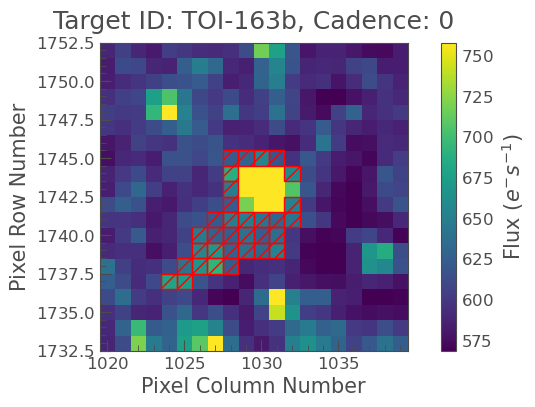

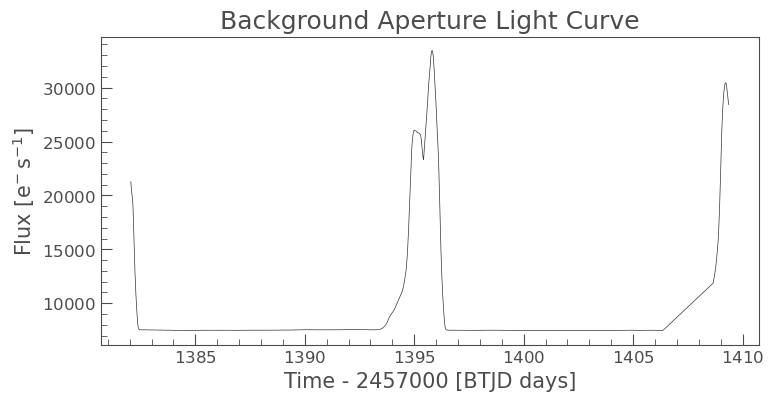

In [254]:
# Background lightcurve

outer_region = (tpf.create_threshold_mask(threshold=1).astype(int) - aper.astype(int)).astype(bool)
tpf.plot(aperture_mask=outer_region); 

uncorrected_lc_bkg = tpf.to_lightcurve(aperture_mask=outer_region)
uncorrected_lc_bkg.plot();
plt.title('Background Aperture Light Curve', fontsize=18)


Text(0.5, 1.0, 'Aperture Light Curve')

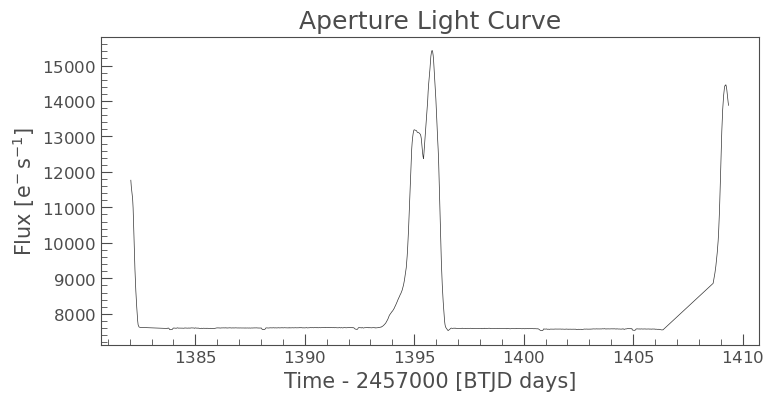

In [255]:
# Star lightcurve again
uncorrected_lc.plot();
plt.title('Aperture Light Curve', fontsize=18)

Comparing both light curves, the elevated baseline in both curves, represented by the peaks/gaussian elevation, corresponds to the scattering light from both the Earth and the Moon. The baseline is elevated at maximum 7000 e/s, almost the double of the baseline(~8000).

This is caused by the moon's phases.

Finally, the lightcurve for TOI-163b is affected by scattering light, showing a neccesity for a correction to be able to study the planet transit.

# Lightcurve correction

Firstly, let's use a linear regression algorithm to asses the scattering light in the lightcurve. For this, the regression corrector with a design matrix can do this.

As a first step, the regressors, independent variables, are defined as an array with shape ntime x npixels outside of the aperture. Then, the Design Matrix or the regressor matrix is costructed as a two-dimensional array that holds multiple columns, each representing a single regressor.

In [256]:
regressors = tpf.flux[:, ~aper]
dm = lk.DesignMatrix(regressors, name='regressors')
dm

regressors DesignMatrix (1077, 390)

Now, the design matrix is too large for the computer to detrend the lightcurve, so by using Principal Component Analysis, the size of the matrix is reduced.

Doing this can remove some of the stochastic noise in the detrending vectors and avoid pixels that have intrinsic variability that can be confused with the signal of our target.

In [257]:
# Reduce dm to 10 detrend vectors
dm = dm.pca(10)
reduced_dm = dm.append_constant()

The reduced matrix is plotted below

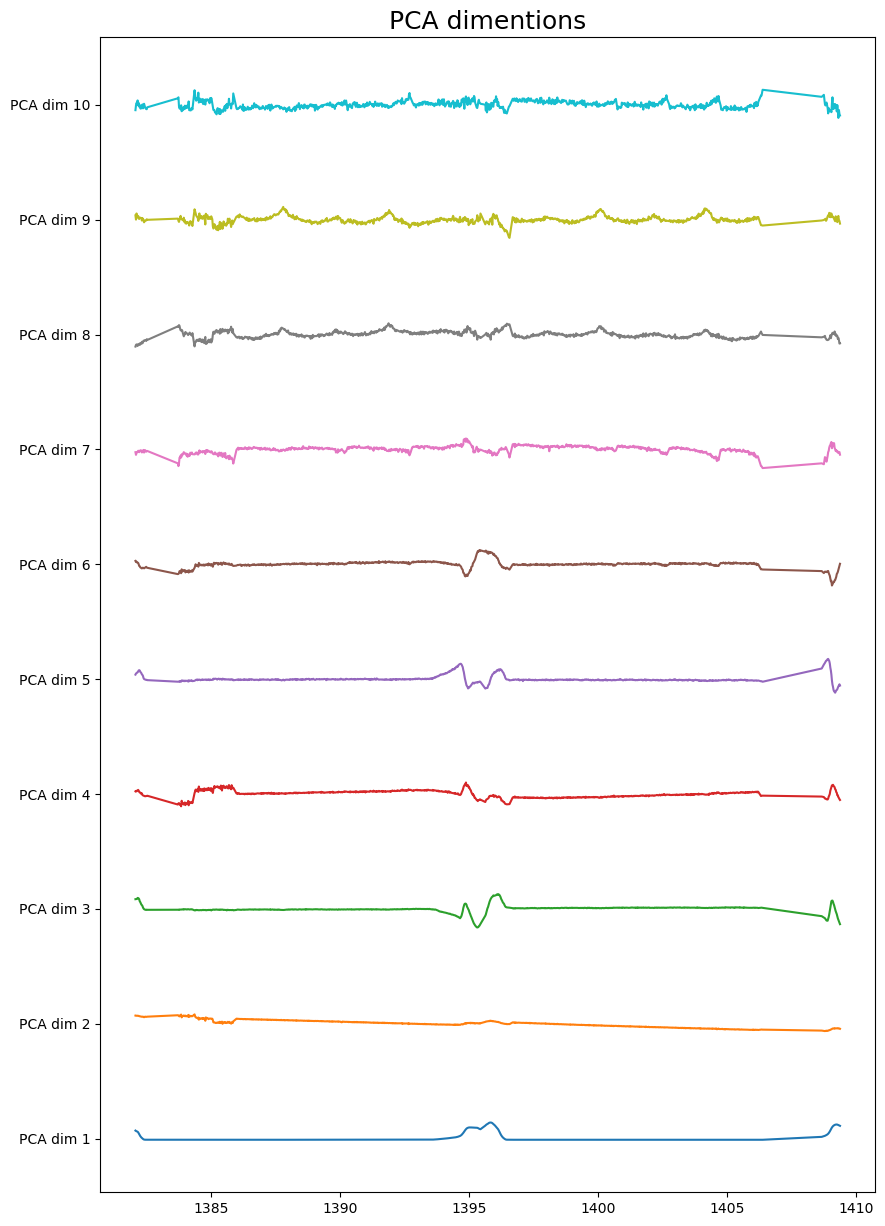

In [384]:
# Visualize PCA dimentions

fig, ax = plt.subplots(figsize=(10, 1.5*10))

ax.plot(tpf.time.value, dm.values + np.arange(10))
ax.set_yticks(np.arange(10))
ax.set_yticklabels(['PCA dim %s' %i for i in range(1,10+1)])
ax.set_title('PCA dimentions', fontsize=18)

plt.show()

Now with the design matrix defined, the RegressionCorrector class from lightkurve, aplly linear regresion to detrend the uncorrected lightcurve.

Then according to the model, there can be a necessity to subtract the model flux value at the 10th percentil if the model is below 0.

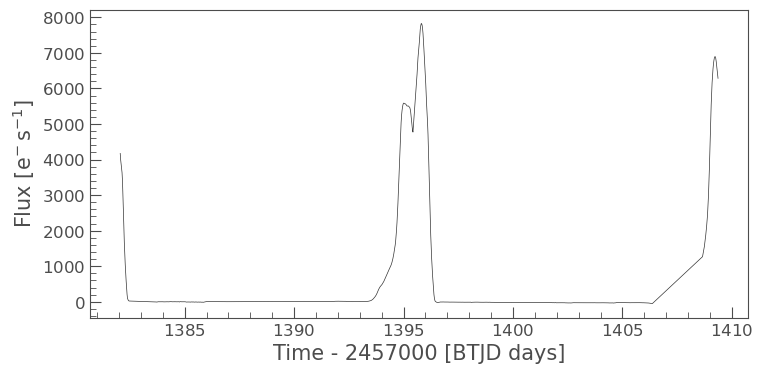

In [258]:
uncorrected_lc = uncorrected_lc.remove_nans()
rc = lk.RegressionCorrector(uncorrected_lc)
corrected_ffi_lc = rc.correct(reduced_dm)

# Let's see the model
model = rc.model_lc
model.plot();

As the model is not below 0, there's not a necessity to add 10th perecentil.

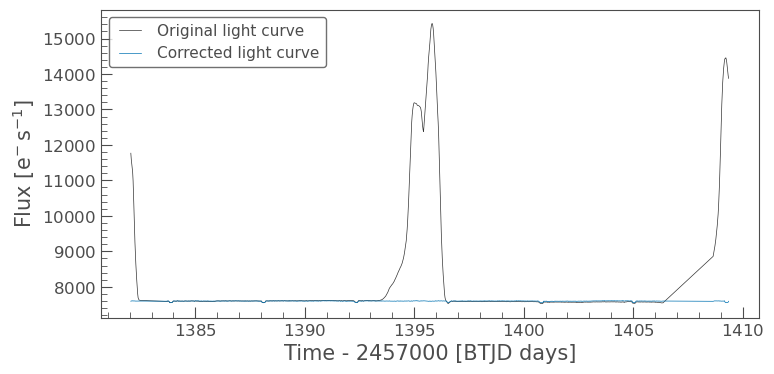

In [260]:
corrected_ffi_lc = uncorrected_lc - rc.model_lc

ax = uncorrected_lc.plot(label='Original light curve')
corrected_ffi_lc.plot(ax=ax, label='Corrected light curve');

To review the correction, only the planet transit should be consider as outlier for the model.
The diagnose is plotted below.

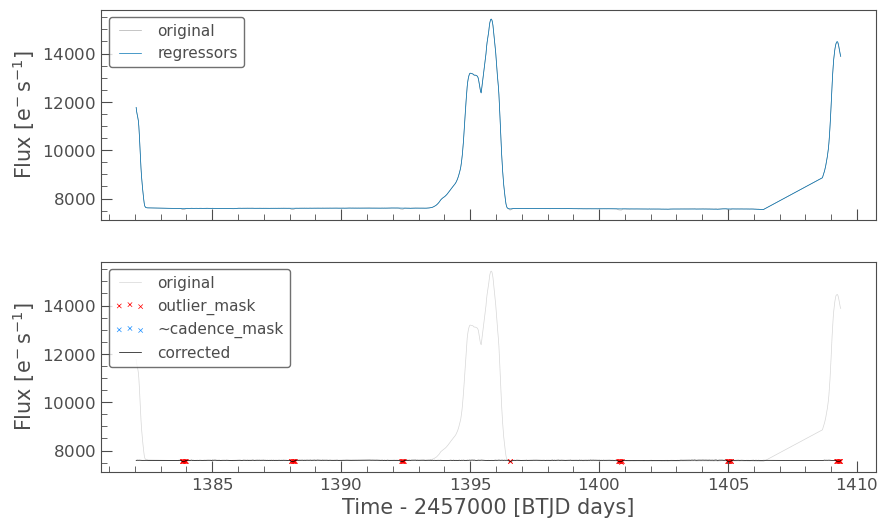

In [262]:
rc.diagnose();
#  The outliers would be the planet transit

With this, the TOI-163b transit is clear in the baseline and declared as the outliers in the model, then the corrected lightcurve is plotted below.

Text(0.5, 1.0, 'Corrected Aperture Light Curve')

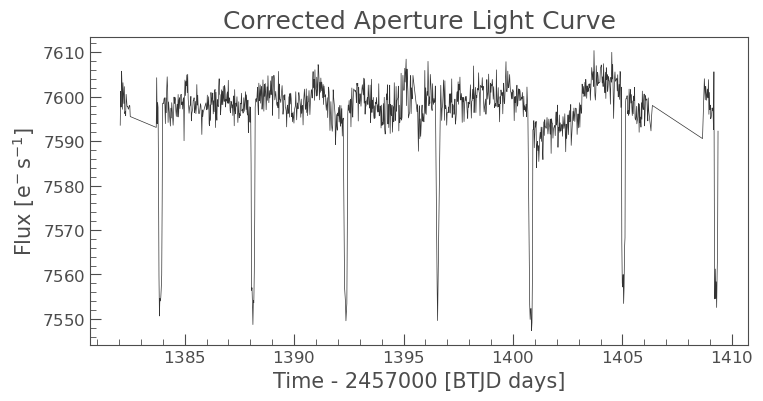

In [277]:
corrected_ffi_lc.plot();
plt.title('Corrected Aperture Light Curve', fontsize=18)

Although the correction was done properly, it is important to know that the aperture's decision, the number of detrended vectors reduced and the decision to not substract the percentile to the model are the main sources of error.

# Second Lightcurve correction

Now, for a second correction, a mcmc gaussian correction is going to be done. Firstly the total flux and time values are extracted from the lightkurve class.

In [328]:
x = tpf.time.value
y_obs = np.sum(tpf.flux[:,aper], axis=1).value

Now, as seen before, the uncorrected lightcurve has the kind-of gaussian peaks created by the scattered light, then the model, likelihood are created for a multiple 1-D gaussian model.

In [279]:
def model(params, x):


    def gaussian(x, amp, mean, stddev):
        return amp * np.exp(-(x - mean)**2 / (2 * stddev**2))


    num_gaussians = len(params) // 3
    result = np.zeros_like(x)
    
    for i in range(num_gaussians):
        result += gaussian(x, *params[i*3:i*3+3])
    
    return result


def log_likelihood(params, x, y_obs):
    # Calculate the model values for each peak
    models = model(params, x)

    # Compute the residuals
    residuals = y_obs - models
    # Calculate the log likelihood
    return -0.5 * np.sum(residuals ** 2)


We define priors for the three parameters of each Gaussian component in the model.

- The amplitude prior reflects the data by using the difference between the baseline and the peak height in the light curve.
- The mean prior incorporates information about the peak location by setting it to the visually identified peak time on the x-axis.

However, the current approach for the standard deviation relies on manually adjusting its value until a 'good' prior is achieved. This can be subjective and doesn't fully represent the data, creating a new source of error to the estimation of the model.

Then with the prior, the probability is also defined.

In [403]:
# The initial params are
guess_params = [4200, 1382, 0.2, 7800, 1395.5, 0.5, 6900, 1409.5, 0.5]

# the prior is set at +/- 5 e/s and BTJD days for the amplitude and mean value,
# while for the standard deviation we assume a normal distribution with sigma between 0 and 1

def log_prior(params):
    a, mu1, sigma1, b, mu2, sigma2, c, mu3, sigma3 = params
    if 4295 < a < 4305 and 1390 < mu1 < 1400 and 0 < sigma1 < 1:
        if 4440 < b < 4450 and 1404 < mu2 < 1414 and -1 < sigma2 < 1:
            if 4214 < c < 4224 and  1375 < mu3 < 1385 and 0 < sigma3 < 1:
                return 0
    return -np.inf


def log_probability(params, x, y_obs):
    lp = log_prior(params)
    if not np.isfinite(lp):
        return -np.inf
    return lp + log_likelihood(params, x, y_obs)

Next, the MCMC sampler is initialize and run.

The observed data is plotted with 100 samples of the mcmc best-fitting model below.

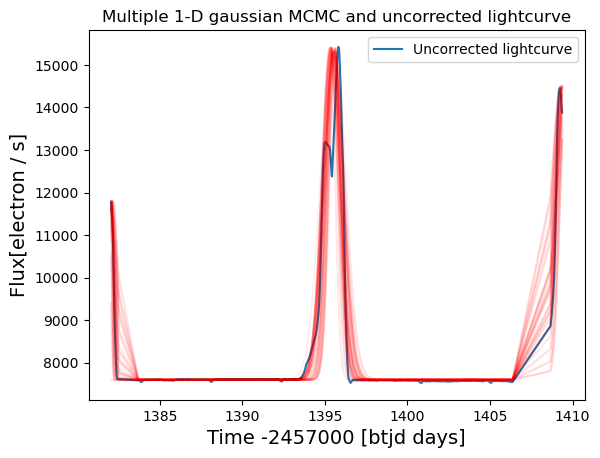

In [404]:
# Initialize the MCMC sampler
ndim = 9  # Number of parameters (mean, sigma, amplitude for each peak)
nwalkers = 32  # Number of walkers
initial_params = np.random.normal(loc=guess_params,
                                  scale=[0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1],
                                  size=(nwalkers, ndim))  # Initial parameter guesses
sampler = emcee.EnsembleSampler(nwalkers, ndim, log_probability, args=(x, y_obs))

# Run the MCMC sampler
nsteps = 1000  # Number of MCMC steps
sampler.run_mcmc(initial_params, nsteps)

# Extract samples from the posterior distribution
samples = sampler.chain[:, :, :].reshape((-1, ndim))


# Plot the original data and the best-fitting model
plt.plot(x, y_obs, label='Uncorrected lightcurve')
for params in samples[np.random.randint(len(samples), size=100)]:
    a, mu1, sigma1, b, mu2, sigma2, c, mu3, sigma3 = params
    model = (
        a*np.exp(-(x-mu1)**2/(2*sigma1**2)) + 
        b*np.exp(-(x-mu2)**2/(2*sigma2**2)) +
        c*np.exp(-(x-mu3)**2/(2*sigma3**2))
    )
    plt.plot(x, model+7600, color='r', alpha=0.03)
plt.ylabel(f'Flux[{uncorrected_lc.flux.unit}]', size=14)
plt.xlabel(f'Time -2457000 [{uncorrected_lc.time.format} days]', size=14)
plt.title('Multiple 1-D gaussian MCMC and uncorrected lightcurve')
plt.legend()
plt.show()

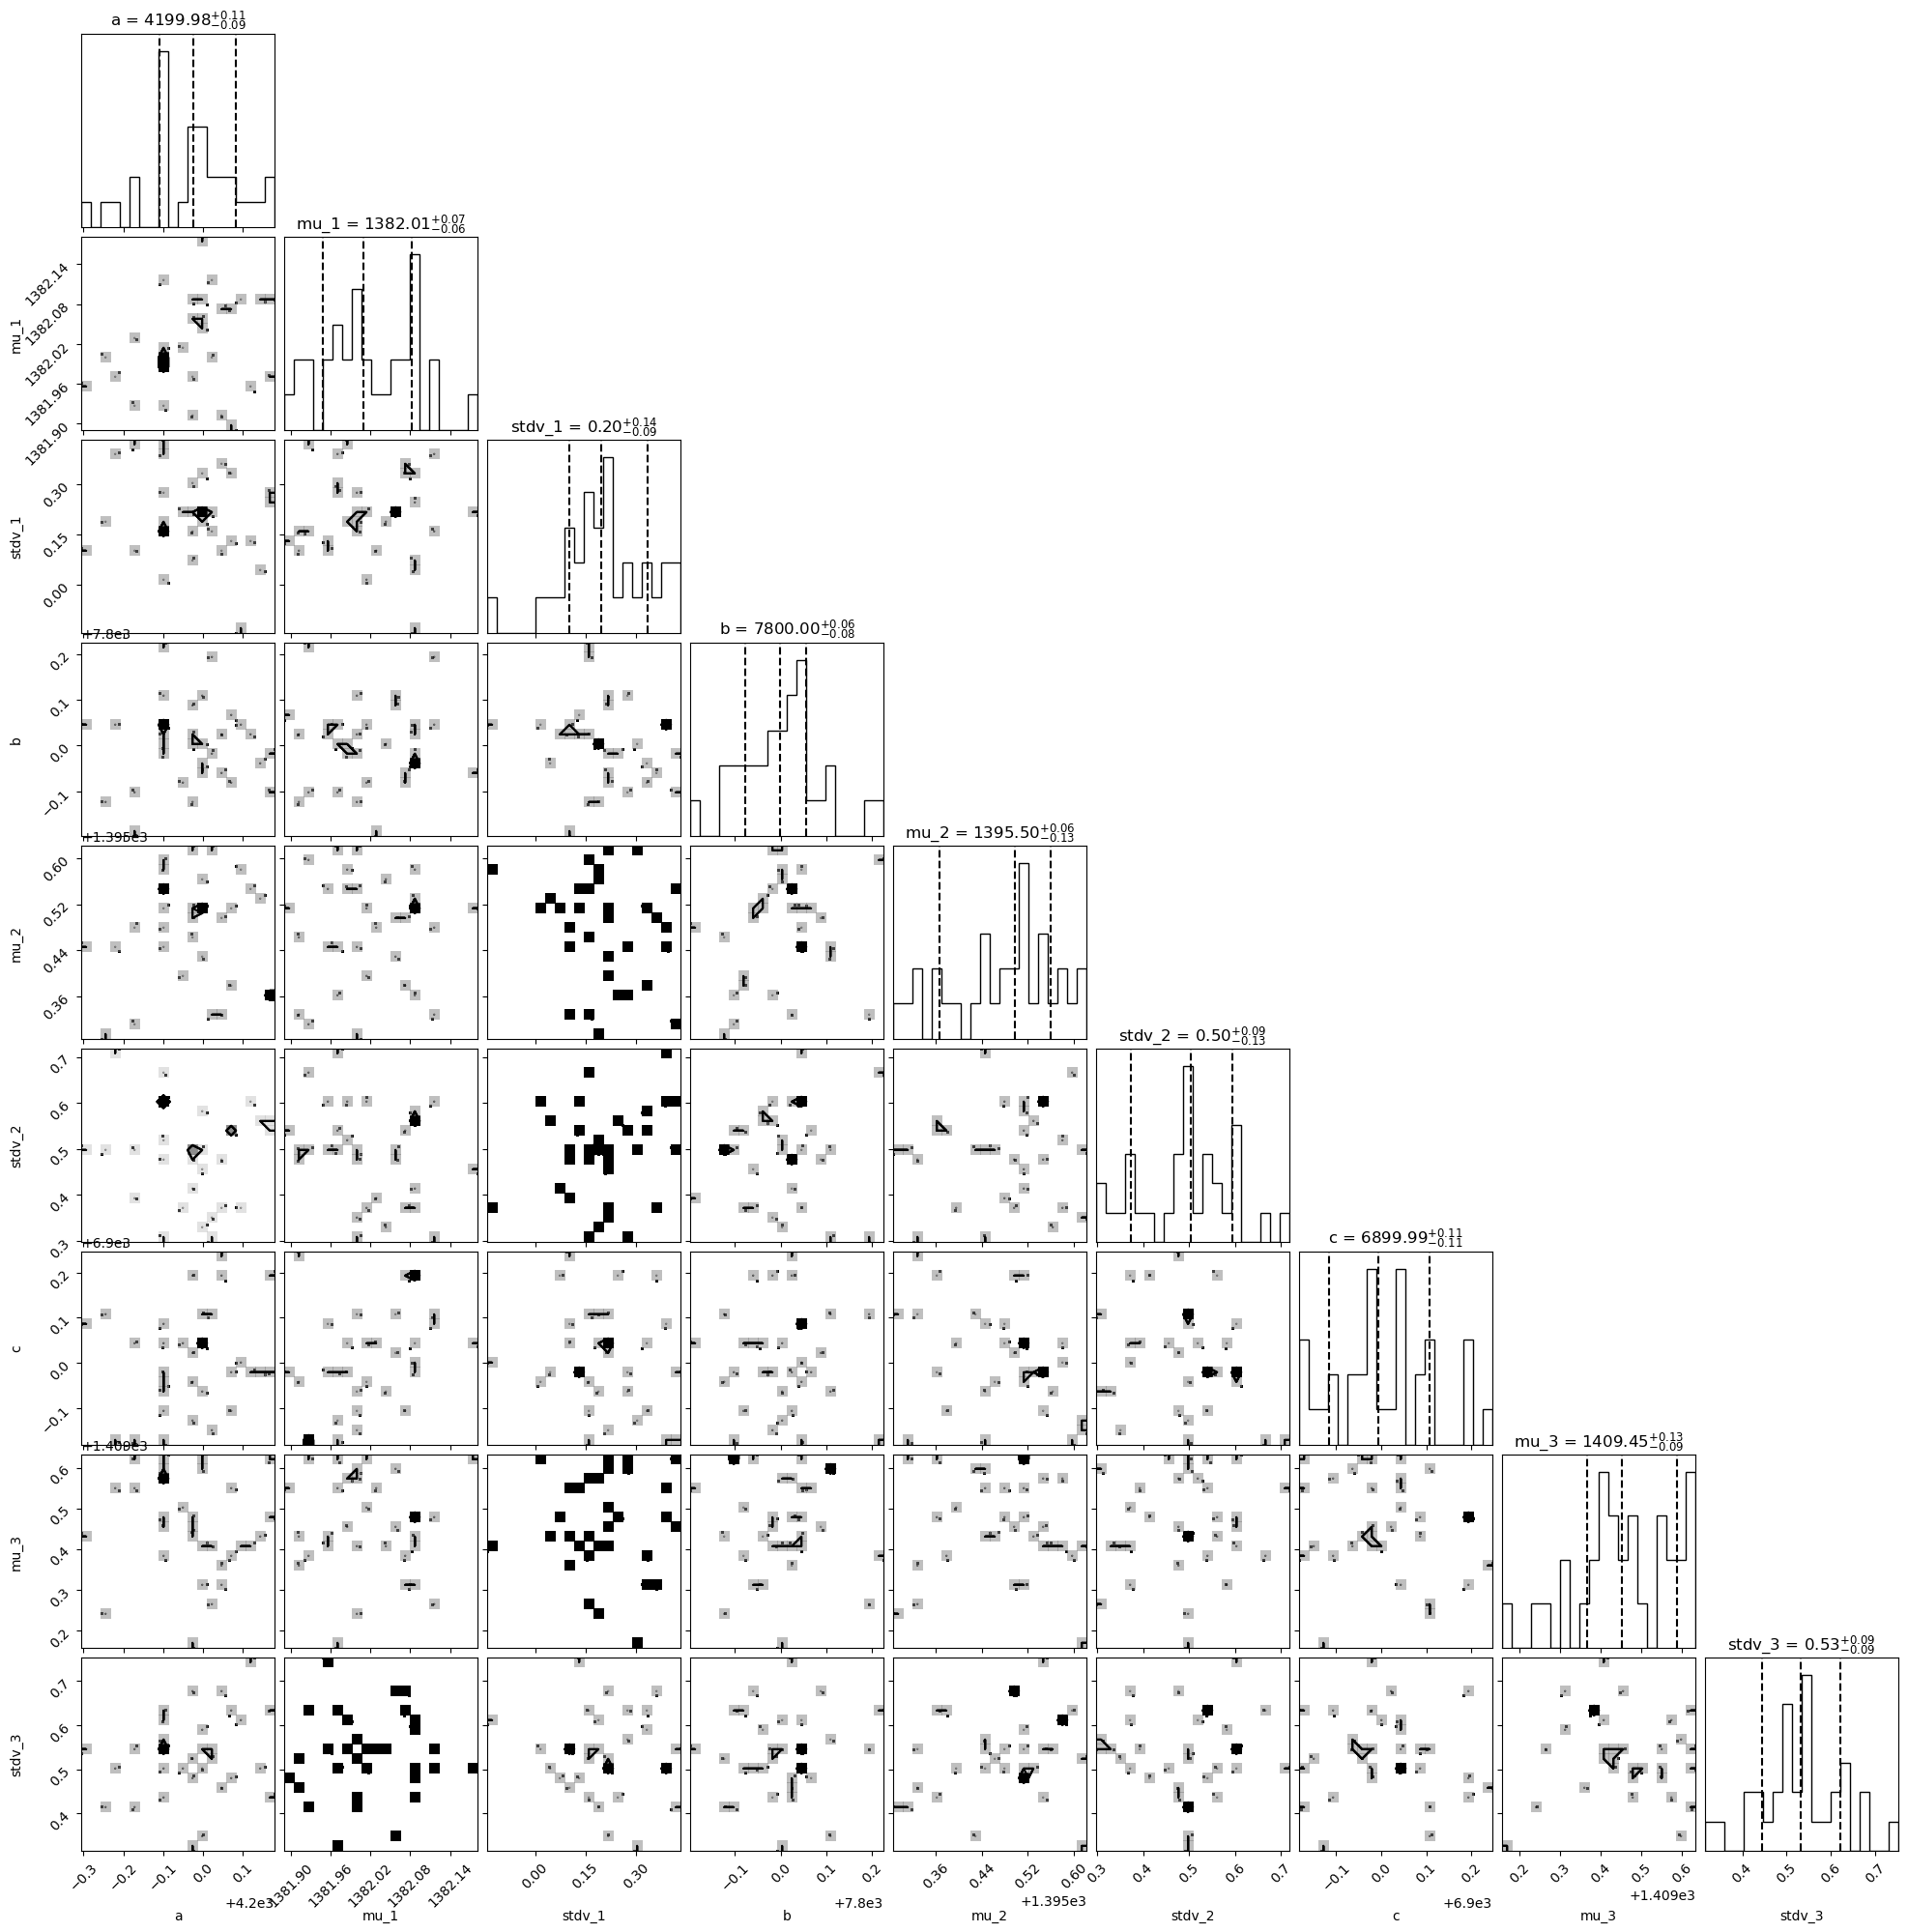

In [411]:
import corner

# Plot the corner plot
fig = corner.corner(samples, 
                    labels=["a", "mu_1", "stdv_1", "b", "mu_2", "stdv_2", "c", "mu_3", "stdv_3"],
                    quantiles=[0.16, 0.5, 0.84],
                    show_titles=True, title_kwargs={"fontsize": 12})

# Show the plot
plt.show();


For the final correction step, the model is subtracted from the uncorrected light curve. To ensure a representative model for subtraction, the mean value of the MCMC simulation are going to be the final parameters.

As MCMC captures central tendency taking the mean value of the parameters effectively captures the trend in the data. Also, by using the mean, we avoid selecting a single, potentially biased, model sample for subtraction. The mean represents a more robust and unbiased estimate of the average model behavior.

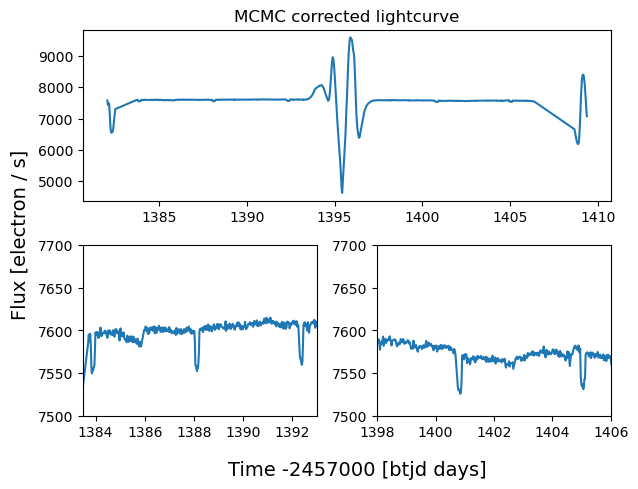

In [406]:
params = samples[np.random.randint(len(samples), size=100)]
mean_params = np.mean(params, axis=0)

def model(params, x):


    def gaussian(x, amp, mean, stddev):
        return amp * np.exp(-(x - mean)**2 / (2 * stddev**2))


    num_gaussians = len(params) // 3
    result = np.zeros_like(x)
    for i in range(num_gaussians):
        result += gaussian(x, *params[i*3:i*3+3])
    
    return result

residuals = y_obs - model(mean_params, x)

fig = plt.figure(tight_layout=True)
gs = gridspec.GridSpec(2, 2)

ax = fig.add_subplot(gs[0, :])
ax.plot(x, residuals)
ax.set_ylabel('   ')
ax.set_title('MCMC corrected lightcurve')
fig.text(0.01, 0.5, f'Flux [{uncorrected_lc.flux.unit}]', size=14, va='center', rotation='vertical')
fig.text(0.35, 0.01, f'Time -2457000 [{uncorrected_lc.time.format} days]', size=14, va='center', rotation='horizontal')

ax1 = fig.add_subplot(gs[1, 0])
ax1.plot(x, residuals)
ax1.set_ylim(7500, 7700)
ax1.set_xlim(1383.5, 1393)

ax2 = fig.add_subplot(gs[1, 1])
ax2.plot(x, residuals)
ax2.set_ylim(7500, 7700)
ax2.set_xlim(1398, 1406)
ax2.set_xlabel('   ')

fig.align_labels()

plt.show()

This model has to be perfected as the scattered light is not fully accounted for, a way to do this is add a gaussian to separate the middle peak, also, a better estimation of the deviation standard prior for every gaussian is needed.

# De-trended 2-min cadence